In [1]:
import numpy as np
from math import inf
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def load_simple_data():
    data_mat = np.matrix(
        [
            [1., 2.1],
            [2., 1.1],
            [1.3, 1.],
            [1., 1.],
            [2., 1.],
        ]
    )
    class_labels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return data_mat, class_labels


data_mat, class_labels = load_simple_data()

## 构建弱分类器

这里的弱分类器是单层决策树

In [3]:
def stump_classify(data_matrix, dimen, thresh_val, thresh_ineq):
    """
    通过阈值比较对数据进行分类
    :param data_matrix:
    :param dimen:
    :param thresh_val:
    :param thresh_ineq:
    :return:
    """
    ret_array = np.ones((np.shape(data_matrix)[0], 1))
    if thresh_ineq == 'lt':
        ret_array[data_matrix[:, dimen] <= thresh_val] = -1.0  # 数组过滤
    else:
        ret_array[data_matrix[:, dimen] > thresh_val] = -1.0
    return ret_array


def build_stump(data_arr, class_labels, d):
    """
    构建最佳的单层决策树
    遍历每个特征的可能取值，逐一尝试，然后寻找分类误差最小的特征和取值作为划分

    :param data_arr:
    :param class_labels:
    :param d: 权重向量
    :return:
    """
    data_matrix = np.mat(data_arr)
    label_mat = np.mat(class_labels).T
    m,n = np.shape(data_matrix)
    num_steps = 10.0
    best_stump = {}  # 存储在当前权重d的条件下，单层最佳决策树的相关信息
    best_clas_est = np.mat(np.zeros((m, 1)))
    min_error = inf  #初始错误率：正无穷

    # 遍历所有特征
    for i in range(n):
        # 计算步长
        range_min = data_matrix[:, i].min()
        range_max = data_matrix[:, i].max()
        step_size = (range_max - range_min) / num_steps

        # 根据步长遍历
        for j in range(-1, int(num_steps) + 1):

            # 大于、小于两种情况
            for inequal in ['lt', 'gt']:
                thresh_val = (range_min + float(j) * step_size)
                predicted_vals = stump_classify(data_matrix, i, thresh_val, inequal)
                err_arr = np.mat(np.ones((m, 1)))
                err_arr[predicted_vals == label_mat] = 0

                # 加权错误率
                weighted_error = d.T * err_arr

                # print("split：dim %d, thresh %.2f, thresh ineqal：%s, the weighted error is %.3f" % (i, thresh_val, inequal, weighted_error))

                if weighted_error < min_error:
                    min_error = weighted_error
                    best_clas_est = predicted_vals.copy()
                    best_stump['dim'] = i
                    best_stump['thresh'] = thresh_val
                    best_stump['ineq'] = inequal
    return best_stump, min_error, best_clas_est


d = np.mat(np.ones((5, 1)) / 5)
build_stump(data_mat, class_labels, d)

({'dim': 0, 'ineq': 'lt', 'thresh': 1.3}, matrix([[ 0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

## AdaBoost

AdaBoost 是 adaptive boosting（自适应 boosting ）的缩写。

其运行过程如下：

训练数据中的每个样本，并赋予其一个权重，这些权重构成了向量d。一开始，这些权重都初始化成相等值。首先在训练数据上训练出一个弱分类器并计算该分类器的错误率，然后在同一数据集上再次训练弱分类器。在分类器的第二次训练当中，将会重新调整每个样本的权重，其中第一次分对的样本的权重将会降低，而第一次分错的样本的权重将会提高。为了从所有弱分类器中得到最终的分类结果，AdaBoost为每个分类器都分配了一个权重值alpha，这些 alpha 值是基于每个弱分类器的错误率进行计算的。其中，错误率 $\varepsilon$ 的定义为：
$$ \varepsilon = \frac{未正确分类的样本数目}{所有的样本数目} $$

$\alpha$ 的计算公式为
$$ \alpha = \frac{1}{2}\ln{\frac{1-\varepsilon}{\varepsilon}} $$

计算出 alpha 值之后，可以对权重向量 d 进行更新，以使得那些正确分类的样本的权重降低而错分样本的权重升高。d 的计算方法如下。
如果某个样本被正确分类，那么该样本的权重更改为：
$$ d_{i}^{(i+1)} = \frac{d_{i}^{(i)}e^{-\alpha}}{sum(d)} $$
而如果某个样本被错分，那么该样本的权重更改为：
$$ d_{i}^{(i+1)} = \frac{d_{i}^{(i)}e^{\alpha}}{sum(d)} $$

在计算出 d 之后，AdaBoost 又开始进入下一轮迭代。AdaBoost 算法会不断地重复训练和调整权重的过程，直到训练错误率为0或者弱分类器的数目达到用户的指定值为止。

In [11]:
def ada_boost_train_ds(data_arr, class_labels, num_it=40):
    """
    基于单层决策树(Decision Stump)的AdaBoost。

    :param data_arr: 数据集
    :param class_labels: 标签
    :param num_it: 迭代次数
    :return:
    """
    weak_class_arr = []
    m = np.shape(data_arr)[0]
    d = np.mat(np.ones((m, 1)) / m)
    agg_class_est = np.mat(np.zeros((m, 1)))  # 记录每个数据点的类别估计累计值

    for i in range(num_it):
        # 弱分类器
        best_stump, error, class_est = build_stump(data_arr, class_labels, d)

        # print("d:", d.T)

        # 当前弱分类器的alpha
        alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))  # max函数防止没有错误时除数为0
        best_stump['alpha'] = alpha
        weak_class_arr.append(best_stump)
        # print("class_est: ", class_est.T)

        # 改变样本的权重
        expon = np.multiply(-1 * alpha * np.mat(class_labels).T, class_est)
        d = np.multiply(d, np.exp(expon))
        d = d / d.sum()

        agg_class_est += alpha * class_est  # 分类累计值
        # print("agg_class_est", agg_class_est.T)

        # 错误率统计
        agg_errors = np.multiply(np.sign(agg_class_est) != np.mat(class_labels).T, np.ones((m, 1)))
        error_rate = agg_errors.sum() / m

        # print("error_rate: ", error_rate)
        if error_rate == 0.0:
            break
    return weak_class_arr, agg_class_est

classifier_arr, agg_class_est= ada_boost_train_ds(data_mat, class_labels, 40)
print(classifier_arr)

[{'thresh': 1.3, 'dim': 0, 'ineq': 'lt', 'alpha': 0.6931471805599453}, {'thresh': 1.0, 'dim': 1, 'ineq': 'lt', 'alpha': 0.9729550745276565}, {'thresh': 0.90000000000000002, 'dim': 0, 'ineq': 'lt', 'alpha': 0.8958797346140273}]


In [12]:
def ada_classify(data_to_class, classifier_arr):
    """
    利用AdaBoost来分类

    :param data_to_class:
    :param classifier_arr:
    :return:
    """
    data_matrix = np.mat(data_to_class)
    m = np.shape(data_matrix)[0]
    agg_class_est = np.mat(np.zeros((m, 1)))

    for i in range(len(classifier_arr)):
        class_est = stump_classify(data_matrix, classifier_arr[i]['dim'], classifier_arr[i]['thresh'], classifier_arr[i]['ineq'])
        agg_class_est += classifier_arr[i]['alpha'] * class_est
        #print(agg_class_est)
    return np.sign(agg_class_est)

ada_classify([[5,5],[0,0]], classifier_arr)

matrix([[ 1.],
        [-1.]])

In [18]:
def load_data_set(filename):
    num_feat = len(open(filename).readline().split('\t'))
    data_mat = []
    label_mat = []
    fr = open(filename)
    for line in fr.readlines():
        line_arr = []
        cur_line = line.strip().split('\t')
        for i in range(num_feat - 1):
            line_arr.append(float(cur_line[i]))
        data_mat.append(line_arr)
        label_mat.append(float(cur_line[-1]))
    return data_mat, label_mat

data_arr, label_arr = load_data_set('data/adaboost/horse_colic_training2.txt')
classifier_arr, agg_class_est = ada_boost_train_ds(data_arr, label_arr, 10)

test_arr, test_label_arr = load_data_set('data/adaboost/horse_colic_test2.txt')
prediction10 = ada_classify(test_arr, classifier_arr)

err_arr = np.mat(np.ones((67, 1)))
err_arr[prediction10 != np.mat(test_label_arr).T].sum()

13.0

## ROC曲线

||+1（预测）|-1（预测）|
|---|:---:|:---:|
|+1（真实结果）|真正例（TP）|伪反例（FN）|
|-1（真实结果）|伪正例（FP）|真反例（TN）|

ROC曲线：

- x轴：伪正例的比例（假阳率=FP/(FP+TN)）
- y轴：正正例的比例（真阳率=TP/(TP+FN)）

注意到，一旦样本固定，那么样本中正例的个数（TP+FN）、反例的个数（FP+TN）也就确定了。可以计算出x_step、y_step：
$$x\_step = \frac{1}{FP+TN}=\frac{1}{样本中正例的个数}$$
$$y\_step = \frac{1}{TP+FN}=\frac{1}{样本中反例的个数}$$

为了创建ROC曲线，首先要将分类样例按照预测强度排序。先认为所有样例都被判为正例，即 $ FN=TN=0 $，即曲线此时对应的点为(1.0, 1.0)。然后按照预测强度从小到大的顺序逐个选取样例，如果样例属于正例，那么真阳率减小y_step（反过来想，我们从不包含这个样本到包含这个样本时，因为样本是正例，所以此时真阳率增加了一个y_step；而绘制ROC曲线时是从包含这个样本到不包含这个样本，所以是真阳率减小y_step）；如果样例属于反例，那么假阳率减小x_step。

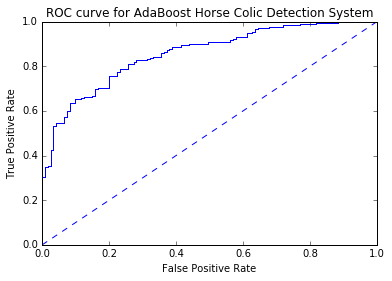

the Area Under the Curve is:  0.8582969635063604


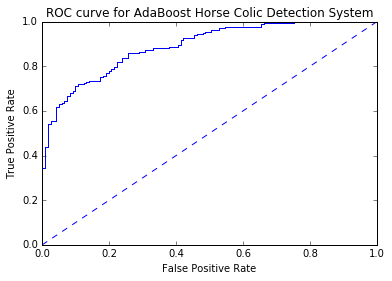

the Area Under the Curve is:  0.8918191104095092


In [39]:
def plot_roc(pred_strengths, class_labels):
    """
    绘制ROC曲线

    :param pred_strengths: 分类器的预测强度
    :param class_labels:
    :return:
    """
    cur = (1.0, 1.0)  # 绘制光标的位置
    y_sum = 0.0  # 用于计算AUC
    num_pos_clas = sum(np.array(class_labels) == 1.0)  # 正例的数目
    y_step = 1 / float(num_pos_clas)
    x_step = 1 / float(len(class_labels) - num_pos_clas)

    # 排序索引
    sorted_indicies = pred_strengths.argsort()

    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    for index in sorted_indicies.tolist()[0]:
        if class_labels[index] == 1.0:
            del_x = 0
            del_y = y_step
        else:
            del_x = x_step
            del_y = 0
            y_sum += cur[1]
        ax.plot([cur[0], cur[0] - del_x], [cur[1], cur[1] - del_y], c='b')
        cur = (cur[0] - del_x, cur[1] - del_y)
    ax.plot([0,1], [0,1], 'b--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for AdaBoost Horse Colic Detection System')
    ax.axis([0,1,0,1])
    plt.show()
    print("the Area Under the Curve is: ", y_sum * x_step)

    
data_arr, label_arr = load_data_set('data/adaboost/horse_colic_training2.txt')
classifier_arr, agg_class_est = ada_boost_train_ds(data_arr, label_arr, 10)
plot_roc(agg_class_est.T, label_arr)

classifier_arr, agg_class_est = ada_boost_train_ds(data_arr, label_arr, 40)
plot_roc(agg_class_est.T, label_arr)